shape: (1128, 10)
  Compound ID  ESOL predicted log solubility in mols per litre  \
0   Amigdalin                                           -0.974   
1    Fenfuram                                           -2.885   
2      citral                                           -2.579   
3      Picene                                           -6.618   
4   Thiophene                                           -2.232   

   Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  \
0               1           457.432                        7                3   
1               1           201.225                        1                2   
2               1           152.237                        0                0   
3               2           278.354                        0                5   
4               2            84.143                        0                1   

   Number of Rotatable Bonds  Polar Surface Area  \
0                          7              202.

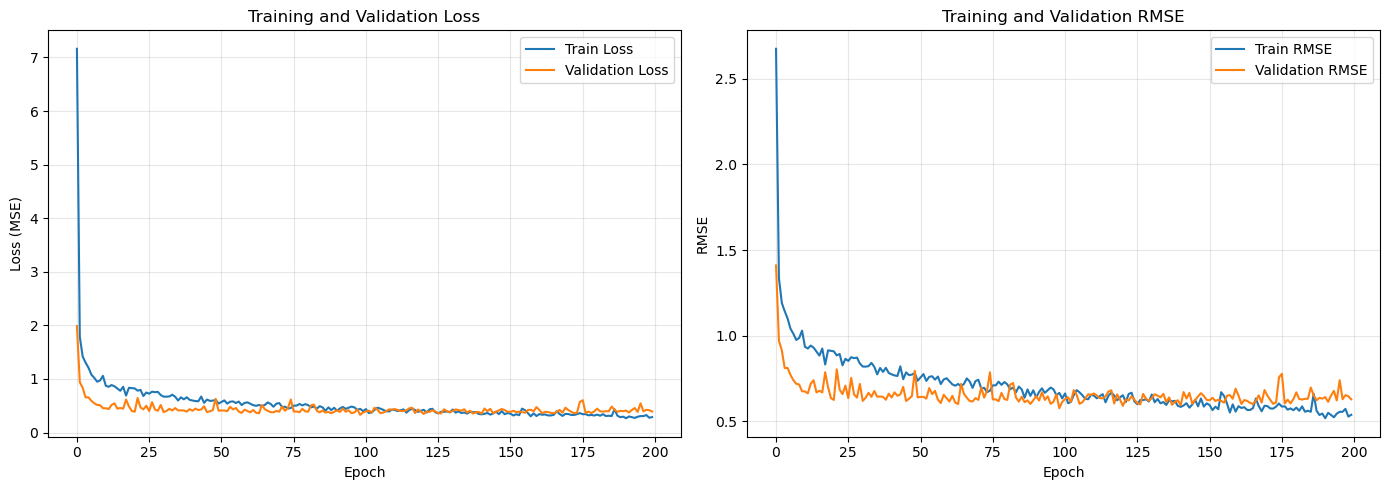

test set results
RMSE: 0.7150
MAE:  0.4742
R²:   0.8910


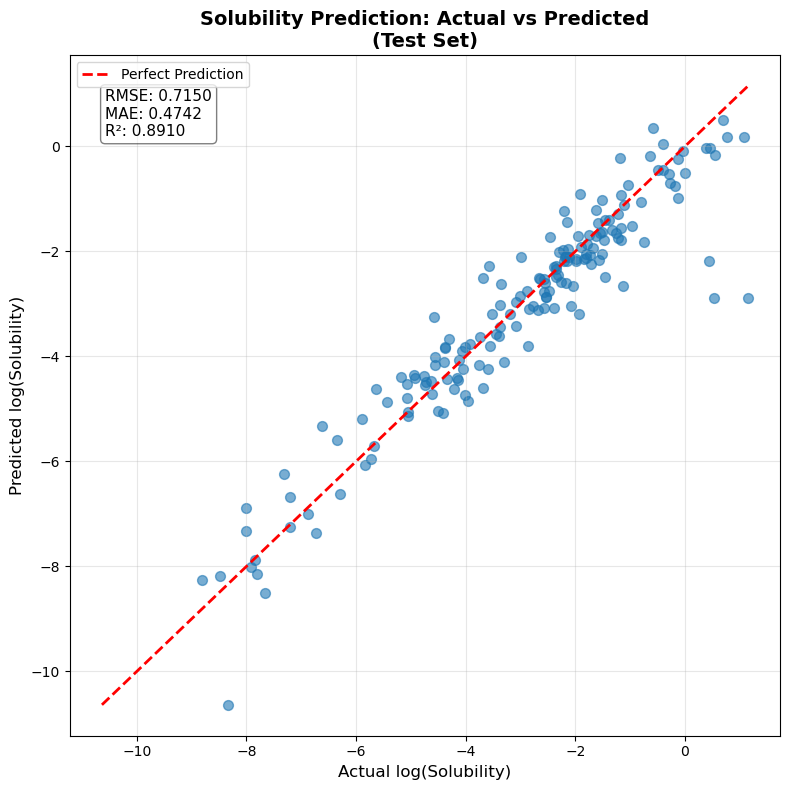

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

url = "https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv"
df = pd.read_csv(url)

print(f"shape: {df.shape}")
print(df.head())
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nTarget statistics:")
print(df['measured log solubility in mols per litre'].describe())

def compute_molecular_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'NumSaturatedRings': Descriptors.NumSaturatedRings(mol),
        'NumAliphaticRings': Descriptors.NumAliphaticRings(mol),
        'RingCount': Descriptors.RingCount(mol),
        'MolMR': Descriptors.MolMR(mol),
        'BalabanJ': Descriptors.BalabanJ(mol),
        'BertzCT': Descriptors.BertzCT(mol),
    }
    
    return descriptors

descriptor_list = []
valid_indices = []

for idx, smiles in enumerate(df['smiles']):
    desc = compute_molecular_descriptors(smiles)
    if desc is not None:
        descriptor_list.append(desc)
        valid_indices.append(idx)

descriptor_df = pd.DataFrame(descriptor_list)
print(f"Got {len(descriptor_df)} molecules")
print(f"Number of features: {descriptor_df.shape[1]}")
print(f"\nDescriptor preview:")
print(descriptor_df.head())
print(f"\nDescriptor statistics:")
print(descriptor_df.describe())

X = descriptor_df.values
y = df.loc[valid_indices, 'measured log solubility in mols per litre'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.176, random_state=42)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature scaling complete")
print(f"Mean of scaled training features: {X_train_scaled.mean():.6f}")
print(f"Std of scaled training features: {X_train_scaled.std():.6f}")

class SolubilityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y).reshape(-1, 1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SolubilityDataset(X_train_scaled, y_train)
val_dataset = SolubilityDataset(X_val_scaled, y_val)
test_dataset = SolubilityDataset(X_test_scaled, y_test)

batch_size = 20
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

class SolubilityPredictor(nn.Module):
    def __init__(self, input_size=13):
        super(SolubilityPredictor, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

model = SolubilityPredictor(input_size=13)
print(model)
print(f"\n# of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training setup
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 200

train_losses = []
val_losses = []
train_rmse = []
val_rmse = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_rmse.append(np.sqrt(train_loss))
    
    model.eval()
    val_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_rmse.append(np.sqrt(val_loss))
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"train Loss: {train_loss:.4f} (RMSE: {np.sqrt(train_loss):.4f}) | "
              f"validation Loss: {val_loss:.4f} (RMSE: {np.sqrt(val_loss):.4f})")

print(f"\ntraining RMSE: {train_rmse[-1]:.4f}")
print(f"validation RMSE: {val_rmse[-1]:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_rmse, label='Train RMSE')
ax2.plot(val_rmse, label='Validation RMSE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE')
ax2.set_title('Training and Validation RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Evaluate on test set
model.eval()
test_predictions = []
test_actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        predictions = model(X_batch)
        test_predictions.extend(predictions.numpy().flatten())
        test_actuals.extend(y_batch.numpy().flatten())

test_predictions = np.array(test_predictions)
test_actuals = np.array(test_actuals)

test_mse = np.mean((test_predictions - test_actuals) ** 2)
test_rmse = np.sqrt(test_mse)
test_mae = np.mean(np.abs(test_predictions - test_actuals))
test_r2 = 1 - (np.sum((test_actuals - test_predictions) ** 2) / 
               np.sum((test_actuals - np.mean(test_actuals)) ** 2))

print("test set results")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE:  {test_mae:.4f}")
print(f"R²:   {test_r2:.4f}")

# Prediction plot
plt.figure(figsize=(8, 8))
plt.scatter(test_actuals, test_predictions, alpha=0.6, s=50)

min_val = min(test_actuals.min(), test_predictions.min())
max_val = max(test_actuals.max(), test_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual log(Solubility)', fontsize=12)
plt.ylabel('Predicted log(Solubility)', fontsize=12)
plt.title('Solubility Prediction: Actual vs Predicted\n(Test Set)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

textstr = f'RMSE: {test_rmse:.4f}\nMAE: {test_mae:.4f}\nR²: {test_r2:.4f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

In [2]:
# Save predictions plot
plt.figure(figsize=(8, 8))
plt.scatter(test_actuals, test_predictions, alpha=0.6, s=50)
min_val = min(test_actuals.min(), test_predictions.min())
max_val = max(test_actuals.max(), test_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual log(Solubility)', fontsize=12)
plt.ylabel('Predicted log(Solubility)', fontsize=12)
plt.title('Solubility Prediction: Actual vs Predicted\n(Test Set)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
textstr = f'RMSE: {test_rmse:.4f}\nMAE: {test_mae:.4f}\nR²: {test_r2:.4f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, 
         fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.tight_layout()
plt.savefig('predictions.png', dpi=300, bbox_inches='tight')
plt.close()

# Save training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(train_rmse, label='Train RMSE')
ax2.plot(val_rmse, label='Validation RMSE')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('RMSE')
ax2.set_title('Training and Validation RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.close()

print("Plots saved!")

Plots saved!
